# Developing a Goal Probability Model

This notebook walks through the process of utilizing data from the NHL's public API to develop features used to predict a probability of a goal for each shot in the 2019-2020 season.

While the NHL API is not publicly documented by the NHL, fine folks of the internet have done some heavy lifting. Check that info out [here](https://github.com/dword4/nhlapi).

In [2]:
import pandas as pd
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import math

# Use this to change how many columns are displayed
#pd.options.display.max_columns = 99

Import a csv containing data aggregated from the NHL API

In [3]:
df = pd.read_csv('./data/playLibrary_v2.csv')

Take a quick look at the data types in each column.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65895 entries, 0 to 65894
Data columns (total 12 columns):
play                65895 non-null object
shooter             65895 non-null int64
goalie              65895 non-null int64
shooterTeamScore    65895 non-null int64
goalieTeamScore     65895 non-null int64
shooterHomeAway     65895 non-null object
period              65895 non-null int64
time                65895 non-null int64
x                   65895 non-null float64
y                   65895 non-null float64
shotType            65895 non-null object
manAdvantageDiff    65895 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 6.0+ MB


In [5]:
df.head()

,play,shooter,goalie,shooterTeamScore,goalieTeamScore,shooterHomeAway,period,time,x,y,shotType,manAdvantageDiff
0,SHOT,8475268,8471239,0,0,away,1,29,48.0,-22.0,Snap Shot,0
1,SHOT,8478401,8476316,0,0,home,1,105,86.0,-6.0,Snap Shot,-1
2,SHOT,8473618,8471239,0,0,away,1,251,66.0,11.0,Wrist Shot,0
3,SHOT,8478891,8471239,0,0,away,1,254,54.0,4.0,Wrist Shot,0
4,SHOT,8477425,8476316,0,0,home,1,391,52.0,36.0,Snap Shot,0


### Create some new features (e.g., distance from net) for our dataframe

Create score difference category

In [6]:
df['scoreDiff'] = df['shooterTeamScore'] - df['goalieTeamScore']

Create a categorical OT yes/no column

In [7]:
df['isOT'] = (df['period']/4).apply(lambda x: math.floor(x))

Create distance from goal

In [8]:
df['distance'] = ((89 - df['x'])*(89 - df['x']) + (df['y']*df['y']))**(0.5)

Create angle from goal (where the angle is the degrees from a line bisecting the ice into upper/lower halves).

In [9]:
df['angle'] = (df['y']/df['distance']).apply(lambda x: math.asin(x)*180/math.pi)

Create a categorical location

In [10]:
df['shooterIsHome'] = pd.get_dummies(df['shooterHomeAway'],drop_first=True)

Create categorical shot types

In [11]:
df = df.join(pd.get_dummies(df['shotType'],drop_first=True))

Create categorical shooter IDs (**Note: This will create A LOT of new columns.**)

In [12]:
df = df.join(pd.get_dummies(df['shooter']))

Create our target categorical variable

In [13]:
df['target'] = pd.get_dummies(df['play'])['GOAL']

## Model Development
<hr>

Let's look at the columns (besides the binary player ID columns) we have to work with again.

In [14]:
df.columns[0:23]

Index(['play', 'shooter', 'goalie', 'shooterTeamScore', 'goalieTeamScore',
       'shooterHomeAway', 'period', 'time', 'x', 'y', 'shotType',
       'manAdvantageDiff', 'scoreDiff', 'isOT', 'distance', 'angle',
       'shooterIsHome', 'Deflected', 'Slap Shot', 'Snap Shot', 'Tip-In',
       'Wrap-around', 'Wrist Shot'],
      dtype='object')

### Logistic Regression

For logistic regression, we'll drop the columns that we've converted to categorical variables (e.g., **shotType, play**), those that may pose collinearity problems with our newly created features (e.g., **period, x, y**), and our **target** column.

In [15]:
X = df.drop(columns=['target','period','shotType','shooterHomeAway','goalie','shooter','play','shooterTeamScore',\
                    'goalieTeamScore','x','y'])
y = df['target']

Import our dependencies for logistic regression. Sklearn's {Model}CV performs a cross-validation using that particular {Model}. 

In [16]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

Improve regression performance / convergence by scaling our features. Additionally, we split our dataset into 1/2 training (which will be further partitioned for cross-validation) and 1/2 testing.

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=0.5, random_state=2)

Fit our logistic regression model to the training data.

In [18]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(trainX, trainy)

Printing out the regression coefficients for each feature. Unsurprisingly, the greatest weight is on the distance from net, with goal probability decreasing with distance. (**Note: because our data are scaled, this coefficient does not represent the change in probability for an unscaled unit change (for distance, one foot) in our feature**)

In [19]:
for idx, coef in enumerate(clf.coef_[0]):
    print(f'{X.columns[idx]}: {coef}')

time: 0.008652980124909098
manAdvantageDiff: 0.0293531791376446
scoreDiff: 0.004293366624986334
isOT: 0.014511970782708104
distance: -0.12499884222401524
angle: 0.007170797251878453
shooterIsHome: 0.0036050270391444063
Deflected: 0.02243103446740198
Slap Shot: -0.01655689615156836
Snap Shot: 0.006416592560706766
Tip-In: 0.035110526493322976
Wrap-around: -0.0075797280337712904
Wrist Shot: -0.022764165044133648
8465009: -0.0072212682653666465
8466138: 0.0031622545862457874
8466139: -0.0022458625401791596
8468493: -0.006083379068021858
8468508: 0.0003568535545064271
8468674: -0.006878804160373385
8469454: 0.004151988103320775
8469455: 0.005045765273776104
8469459: -0.0009318696139561115
8469465: -0.00495288719263593
8470047: 0.003979025406623307
8470110: -0.0031267572813342124
8470144: -0.00430476511135995
8470151: -0.005360931932400115
8470187: -0.007650542927097679
8470257: 0.0052973469355780895
8470281: -0.007608472679701566
8470318: -0.0023821533442600156
8470594: -3.445496714362985e-

#### Scoring

Here's some predicted probability data (in ProbNoGoal, ProbGoal format) for each test sample. Note that the values may be clustering around 0.9-0.91 for a no-goal probability. The average save percentage (which equals saves divided by shots) is around 0.9-0.91 in the NHL. So our model may just be focusing on the distribution of our targets (~10% goals, ~90% no goals). While this may provide decent "reliability," it adds little information to what standard "climatology" would tell us. Let's keep investigating. 

In [20]:
clf.predict_proba(testX)

array([[0.93505437, 0.06494563],
       [0.86330623, 0.13669377],
       [0.93190518, 0.06809482],
       ...,
       [0.92440255, 0.07559745],
       [0.91840292, 0.08159708],
       [0.90539045, 0.09460955]])

Indeed, our model appears to do well, but in reality, is likely just mimicking the background probability of a goal per shot.

In [21]:
clf.score(testX,testy)

0.9094026951560034

As we see below, using a balanced accuracy score (which takes into account imbalanced data) shows that this model is no better than randomly choosing goal ~10% of the time.

In [22]:
metrics.balanced_accuracy_score(testy,clf.predict(testX),adjusted=True)

0.0

Plotting a **ROC Curve** with our test data to investigate the model's diagnostic ability. For more info on receiver operating characteristic curves, head [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

In [23]:
from sklearn import metrics
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [24]:
proba = clf.predict_proba(testX)[:, 1]

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(testy,proba)

In [26]:
import matplotlib.pyplot as plt

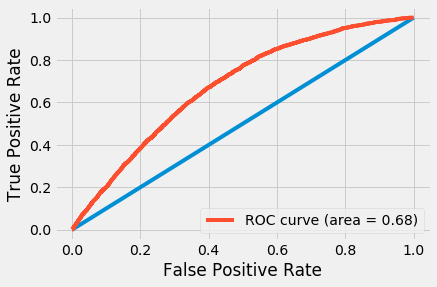

In [27]:
roc_auc = metrics.auc(fpr,tpr)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr,label=f'ROC curve (area = {roc_auc:.2f})')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

While the curve suggests a modest improvement over random guessing of goal/no goal (i.e., it's to the left of the blue line), performance of the model does not appear particularly robust.

Plotting a **Calibration Curve** to investigate model reliability.

In [28]:
prob_true, prob_pred = calibration_curve(testy,proba,n_bins=20,strategy='quantile')

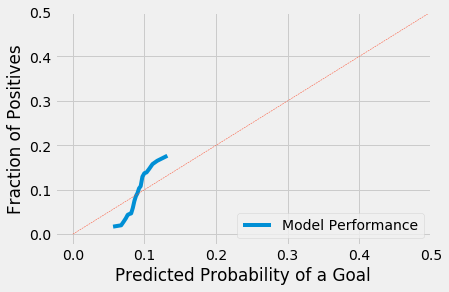

In [29]:
plt.plot(prob_pred, prob_true,label='Model Performance')
plt.plot([0,1],[0,1],linestyle='dashed',linewidth=0.5)
plt.legend(loc='lower right')
plt.xlim([-0.025,0.5])
plt.ylim([-0.025,0.5])
plt.xlabel('Predicted Probability of a Goal')
plt.ylabel('Fraction of Positives')
plt.show()

The reliability curve yields more evidence that our logistic regression is dominated by the goal frequency for all shots. Once the predicted probability increases beyond ~0.09, we see the model begins to underestimate probabilities. Conversely, modeled probabilities less than ~0.09 show an overestimated probabilities when compared to the fraction of positives. This sigmoid curve is indicative of an underconfident, overly conservative model. All told, this model appears not much more useful than randomly guessing one goal per every 10 shots.

#### Resampling to balance dataset

One method we can try to improve performance of logistic regression is to resample our data to balance the dataset (i.e., create the same number of goal/no-goal samples).

In this instance, we will drop 90% of the no-goal samples to create a distribution of about 5000 goals and 5000 no goals. We will then run through the same procedures as before.

In [30]:
dfUnderSample = df.drop(df[df['target'] == 0].sample(frac=.9,random_state=1).index)

In [31]:
X = dfUnderSample.drop(columns=['target','period','shotType','shooterHomeAway','goalie','shooter','play','shooterTeamScore',\
                    'goalieTeamScore','x','y'])
y = dfUnderSample['target']

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=0.5, random_state=2)

In [33]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(trainX, trainy)

In [34]:
clf.predict_proba(testX)

array([[0.44032792, 0.55967208],
       [0.48847477, 0.51152523],
       [0.83132811, 0.16867189],
       ...,
       [0.52309145, 0.47690855],
       [0.23491111, 0.76508889],
       [0.47853115, 0.52146885]])

Based on this score, we can already tell that the new model is much more aggressive in predicting goals, as it's only correct 64% of the time (if we reduce it to a goal/no goal prediction).

In [35]:
clf.score(testX,testy)

0.6436454849498328

Here, our balanced accuracy score suggests at least some increase in skill (relative to the model trained on the imbalanced dataset).

In [36]:
metrics.balanced_accuracy_score(testy,clf.predict(testX),adjusted=True)

0.2890179903796355

Sure enough, over half the samples are now predicted goals (> 50% probability of a goal).

In [37]:
proba = clf.predict_proba(testX)[:, 1]

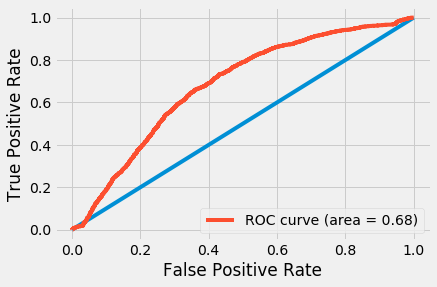

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(testy,proba)
roc_auc = metrics.auc(fpr,tpr)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr,label=f'ROC curve (area = {roc_auc:.2f})')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [39]:
prob_true, prob_pred = calibration_curve(testy,proba,n_bins=20, strategy='quantile')

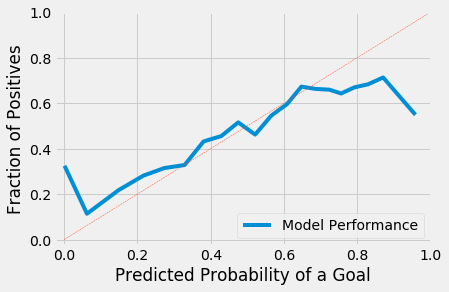

In [40]:
plt.plot(prob_pred, prob_true,label='Model Performance')
plt.plot([0,1],[0,1],linestyle='dashed',linewidth=0.5)
plt.legend(loc='lower right')
plt.xlim([-0.025,1])
plt.ylim([-0.025,1])
plt.xlabel('Predicted Probability of a Goal')
plt.ylabel('Fraction of Positives')
plt.show()

While our new logistic regression now appears to have a much broader distribution of predicted probabilities, we noticed earlier that its classification (calling either a goal or not) score is worse than the prior logistic regression model, which essentially predicts everything as no goal. Certainly, any model that predicts higher than a 50% probability of a goal for a particular shot is likely too confident, given that even the best players tend to have penalty shot/shootout percentages (one of the highest goal probability scenarios) no greater than 50%. So while we did improve the predictive range, it appears that re-sampling made the model too aggressive.

More importantly, it should be noted that the model was run on a test dataset that also is characterized by undersampling of no-goal shots. If we ran this model on the total distribution of samples, we'd likely see that the model is too aggressive at most, if not all, probability bins.

### Gradient Boosting

To head in a little different direction, let's try a non-linear, ensemble model.

In [41]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

As before, we'll create our feature and target data. However, with our ensemble decision-tree model, we'll re-introduce some of the variables that we were worried might cause collinearity issues with our logistic regression.

In [42]:
X = df.drop(columns=['target','period','shotType','shooterHomeAway','goalie','shooter','play'])
y = df['target']

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=0.5, random_state=2)

Create our gradient boosting classifier instance and pass it to another CV method; however, this method also produces calibrated probabilities from the classifier, since gradient boosting does not inherently provide calibrated probabilities.

In [44]:
model = GBC(random_state=2)
calibrated = CalibratedClassifierCV(model, cv=5)

In [45]:
calibrated.fit(trainX, trainy)

CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                 criterion='friedman_mse',
                                                                 init=None,
                                                                 learning_rate=0.1,
                                                                 loss='deviance',
                                                                 max_depth=3,
                                                                 max_features=None,
                                                                 max_leaf_nodes=None,
                                                                 min_impurity_decrease=0.0,
                                                                 min_impurity_split=None,
                                                                 min_samples_leaf=1,
                                                                 min_sam

Predict goal probabilities on our test data using the calibrated model.

In [47]:
proba = calibrated.predict_proba(testX)[:, 1]

The reliability diagram suggests improved calibration with this gradient-boosted model. It's not until ~40% and higher that predicted probabilities appear to become rather unskillful, but low sample size at these probability bins prohibits us from making more robust conclusions.

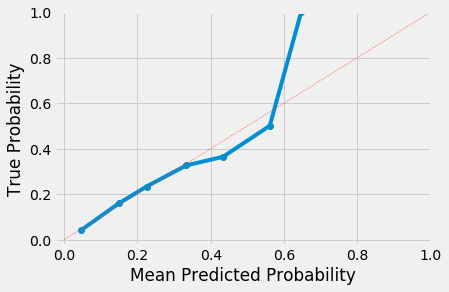

In [48]:
# reliability diagram
fop, mpv = calibration_curve(testy, proba, n_bins=10, normalize=False)
#fop, mpv = calibration_curve(testy, proba, n_bins=30, strategy='quantile', normalize=False)
plt.plot(mpv, fop, marker='o')
plt.plot([0,1],[0,1],linestyle='dashed',linewidth=0.5)
plt.xlim([-0.025,1])
plt.ylim([-0.025,1])
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.show()

Area under the ROC curve has improved as well, versus the logistic regression model.

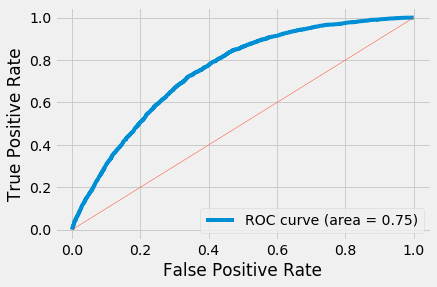

In [49]:
fpr, tpr, thresholds = metrics.roc_curve(testy,proba)
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr,tpr,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],linewidth=0.5)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**There are many more paths we could take to further improve this model: Further feature development (e.g., infer rebound plays, change in angle, etc.), attempting other models (e.g., random forest, SVC), gathering more data, etc. However, given the relatively robust performance of our gradient-boosting model, we will utilize it for deployment with our goalie analysis application.**

Use joblib to persist the model and its associated scaler.

In [44]:
from joblib import dump, load

In [52]:
dump(calibrated, './models/gbGoalie_08032020.joblib')

['./models/gbGoalie_08032020.joblib']

In [46]:
dump(scaler, './models/scaler.bin')

['./models/scaler.bin']